
# Click Spacing Randomization Study

This notebook combines insights from the click-spacing analysis and recovery demos to test whether synthetic click trains with altered spacing can reduce the striations seen in the feature-matrix diagnostics. We build GLM feature sets under multiple spacing regimes and compare their statistical structure.



## Goals
- Recreate the original feature-matrix diagnostics using the *actual* click timings.
- Regenerate the same trials with *randomized* click times that break the 3 ms grid and inspect resulting patterns.
- Produce evenly spaced click trains (e.g. 10 ms interval) to see how coarser spacing affects feature structure.
- Keep all helper utilities inside this notebook for fast experimentation with alternative spacing strategies.


In [70]:

import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

PROJECT_ROOT = Path("../../").resolve()

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 8)
plt.rcParams["font.size"] = 12

print(f"Project root: {PROJECT_ROOT}")


Project root: /home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV


In [71]:
# Helper utilities (self-contained so we do not rely on external Python modules)
from __future__ import annotations

from dataclasses import dataclass
from typing import Any, Dict, Iterable, Literal, Optional, Tuple, Union

try:
    from tqdm import tqdm
except ImportError:  # pragma: no cover - tqdm is optional in notebooks
    tqdm = None

SpacingMode = Literal[
    "actual", "random_uniform", "jitter", "fixed_interval",
    "poisson_continuous", "poisson_discrete_3ms", "poisson_discrete_10ms", "poisson_discrete"
]


@dataclass
class FeatureDataset:
    """Container for GLM feature matrices and associated metadata."""

    X: np.ndarray
    y: np.ndarray
    trial_ids: np.ndarray
    time_bins: np.ndarray
    valid_mask: np.ndarray
    metadata: Dict[str, Any]

    def filtered(self) -> "FeatureDataset":
        """Return a copy containing only observations marked as valid."""

        mask = self.valid_mask
        return FeatureDataset(
            X=self.X[mask],
            y=self.y[mask],
            trial_ids=self.trial_ids[mask],
            time_bins=self.time_bins[mask],
            valid_mask=np.ones(mask.sum(), dtype=bool),
            metadata={**self.metadata, "filtered": True},
        )


def load_session_data(h5_path: Path) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Load trial, click, and DV tables from an HDF5 store."""

    with pd.HDFStore(h5_path, mode="r") as store:
        trial_df = store["trials"]
        click_df = store["clicks"]
        dv_df = store["decision_variables"]
    return trial_df, click_df, dv_df


def gaussian_basis(t: np.ndarray, center: float, width: float, causal: bool = True) -> np.ndarray:
    """Causal Gaussian centred ``center`` seconds after a click."""

    gaussian = (1 / (width * np.sqrt(2 * np.pi))) * np.exp(-((t - center) ** 2) / (2 * width**2))
    if causal:
        gaussian = np.where(t >= 0, gaussian, 0.0)
    return gaussian


def create_click_kernel(dt: float = 0.001, duration: float = 0.003) -> np.ndarray:
    """Raised-cosine (Hann) kernel matching the 3 ms acoustic click envelope."""

    n_samples = int(np.ceil(duration / dt))
    t = np.linspace(0.0, duration, n_samples, endpoint=True)
    envelope = 0.5 * (1 - np.cos(2 * np.pi * t / duration))
    return envelope / envelope.sum()


def make_basis(
    n_basis: int = 10,
    width_min: float = 0.010,
    width_max: float = 0.500,
    offset_ratio: float = 0.5,
    center_jitter: float = 0.0,
    rng: Optional[int] = None,
) -> Tuple[np.ndarray, np.ndarray]:
    """Construct log-spaced Gaussian widths and corresponding centres."""

    random_state = np.random.default_rng(rng)
    widths = np.logspace(np.log10(width_min), np.log10(width_max), n_basis)

    centers = np.zeros(n_basis)
    centers[0] = widths[0] * offset_ratio
    for idx in range(1, n_basis):
        centers[idx] = centers[idx - 1] + offset_ratio * (widths[idx - 1] + widths[idx])

    if center_jitter:
        centers += random_state.uniform(-center_jitter, center_jitter, size=n_basis)

    return centers, widths


def create_trial_features(
    left_clicks: np.ndarray,
    right_clicks: np.ndarray,
    dv_eval_times: np.ndarray,
    centers: np.ndarray,
    widths: np.ndarray,
    trial_duration: float,
    *,
    dt: float = 0.001,
    padding: float = 1.0,
    kernel: Optional[np.ndarray] = None,
    store_convolutions: bool = False,
) -> Tuple[np.ndarray, Optional[Dict[str, Any]]]:
    """Generate GLM features by convolving click trains with causal Gaussians."""

    kernel = create_click_kernel(dt) if kernel is None else kernel

    total_duration = trial_duration + 2 * padding
    n_bins = int(np.ceil(total_duration / dt))
    time_axis = np.arange(n_bins) * dt - padding

    left_train = np.zeros(n_bins)
    right_train = np.zeros(n_bins)

    def _place(train: np.ndarray, clicks: np.ndarray) -> None:
        for click_time in clicks:
            if 0.0 <= click_time <= trial_duration:
                bin_idx = int(np.floor((click_time + padding) / dt))
                for offset, amplitude in enumerate(kernel):
                    target = bin_idx + offset
                    if 0 <= target < n_bins:
                        train[target] += amplitude

    _place(left_train, left_clicks)
    _place(right_train, right_clicks)

    n_basis = len(widths)
    convolved_left = []
    convolved_right = []

    for width, center in zip(widths, centers):
        max_lag = min(6 * width, padding)
        kernel_bins = int(np.ceil(max_lag / dt)) + 1
        time_lags = np.arange(0, kernel_bins * dt, dt)
        causal_kernel = gaussian_basis(time_lags, center, width, causal=True)
        conv_left = np.convolve(left_train, causal_kernel, mode="full")[:n_bins]
        conv_right = np.convolve(right_train, causal_kernel, mode="full")[:n_bins]
        convolved_left.append(conv_left)
        convolved_right.append(conv_right)

    features = np.zeros((len(dv_eval_times), 2 * n_basis))

    for idx, eval_time in enumerate(dv_eval_times):
        bin_idx = int(np.floor((eval_time + padding) / dt))
        for basis_idx in range(n_basis):
            left_conv = convolved_left[basis_idx]
            right_conv = convolved_right[basis_idx]
            if 0 <= bin_idx < len(left_conv):
                features[idx, basis_idx] = left_conv[bin_idx]
                features[idx, n_basis + basis_idx] = right_conv[bin_idx]

    stored = None
    if store_convolutions:
        stored = {
            "time_grid": time_axis,
            "left": convolved_left,
            "right": convolved_right,
            "left_click_times": left_clicks,
            "right_click_times": right_clicks,
        }

    return features, stored


def transform_click_times(
    clicks: np.ndarray,
    trial_duration: float,
    *,
    mode: SpacingMode,
    rng: Optional[np.random.Generator] = None,
    jitter_ms: float = 1.0,
    interval_ms: float = 10.0,
    grid_ms: Optional[float] = None,  # For poisson_discrete mode
    allow_collisions: bool = True,  # NEW: Allow multiple clicks per grid position
) -> np.ndarray:
    """
    Modify click times according to the requested spacing mode.
    
    Modes:
    - actual: Use original click times
    - random_uniform: Uniform random distribution (legacy)
    - poisson_continuous: True Poisson process with exponential inter-arrival times
    - poisson_discrete: Poisson process discretized to specified grid (use grid_ms parameter)
    - poisson_discrete_3ms: Poisson process discretized to 3ms grid
    - poisson_discrete_10ms: Poisson process discretized to 10ms grid
    - jitter: Add random jitter to original times
    - fixed_interval: Fixed spacing (legacy)
    
    Args:
        allow_collisions: If True, multiple clicks can occupy the same grid position.
                         If False, clicks are forced to unique positions (legacy behavior).
    """

    rng = np.random.default_rng() if rng is None else rng
    clicks = np.asarray(clicks, dtype=float)
    n_clicks = len(clicks)

    if n_clicks == 0 or mode == "actual":
        return np.sort(clicks.copy())

    # Calculate base rate from actual data
    base_rate = n_clicks / max(trial_duration, 0.001)  # clicks per second

    if mode == "poisson_continuous":
        # Generate true Poisson process with exponential inter-arrival times
        avg_interval = 1.0 / base_rate
        
        # Generate more intervals than needed to ensure we have enough
        intervals = rng.exponential(avg_interval, size=int(n_clicks * 2))
        click_times = np.cumsum(intervals)
        
        # Keep only clicks within trial duration
        click_times = click_times[click_times < trial_duration]
        
        # If we have too few, generate more
        while len(click_times) < n_clicks:
            extra_intervals = rng.exponential(avg_interval, size=n_clicks)
            last_time = click_times[-1] if len(click_times) > 0 else 0
            extra_times = last_time + np.cumsum(extra_intervals)
            click_times = np.concatenate([click_times, extra_times])
            click_times = click_times[click_times < trial_duration]
        
        # Trim to match original count
        if len(click_times) > n_clicks:
            click_times = click_times[:n_clicks]
        
        return np.sort(click_times)
    
    elif mode == "poisson_discrete":
        # General discretized Poisson - requires grid_ms parameter
        if grid_ms is None:
            raise ValueError("grid_ms parameter required for poisson_discrete mode")
        
        grid_size = grid_ms / 1000.0  # Convert ms to seconds
        
        if allow_collisions:
            # NEW BEHAVIOR: Allow multiple clicks per grid position
            # Generate continuous Poisson process
            avg_interval = 1.0 / base_rate
            
            # Generate clicks
            intervals = rng.exponential(avg_interval, size=int(n_clicks * 1.5))
            continuous_times = np.cumsum(intervals)
            continuous_times = continuous_times[continuous_times < trial_duration]
            
            # Make sure we have enough clicks
            while len(continuous_times) < n_clicks:
                extra_intervals = rng.exponential(avg_interval, size=n_clicks)
                last_time = continuous_times[-1] if len(continuous_times) > 0 else 0
                extra_times = last_time + np.cumsum(extra_intervals)
                continuous_times = np.concatenate([continuous_times, extra_times])
                continuous_times = continuous_times[continuous_times < trial_duration]
            
            # Trim to exact count
            if len(continuous_times) > n_clicks:
                continuous_times = continuous_times[:n_clicks]
            
            # Discretize to grid - ALLOW DUPLICATES
            discrete_times = np.round(continuous_times / grid_size) * grid_size
            discrete_times = np.clip(discrete_times, 0, trial_duration)
            
            # Sort but keep all clicks (including duplicates)
            return np.sort(discrete_times)
            
        else:
            # LEGACY BEHAVIOR: Force unique positions
            # Adjust rate based on grid size (larger grids need more adjustment)
            rate_adjustment = 1.0 + (grid_ms / 10) * 0.1  # Scale adjustment with grid size
            adjusted_rate = base_rate * rate_adjustment
            avg_interval = 1.0 / adjusted_rate
            
            # Generate continuous Poisson process
            intervals = rng.exponential(avg_interval, size=int(n_clicks * 2))
            continuous_times = np.cumsum(intervals)
            continuous_times = continuous_times[continuous_times < trial_duration]
            
            # Discretize to specified grid
            discrete_times = np.round(continuous_times / grid_size) * grid_size
            discrete_times = np.unique(discrete_times)  # Force unique
            
            # If too few due to collisions, regenerate with higher rate
            attempts = 0
            while len(discrete_times) < n_clicks * 0.9 and attempts < 5:
                rate_adjustment *= 1.05
                adjusted_rate = base_rate * rate_adjustment
                avg_interval = 1.0 / adjusted_rate
                intervals = rng.exponential(avg_interval, size=int(n_clicks * 2))
                continuous_times = np.cumsum(intervals)
                continuous_times = continuous_times[continuous_times < trial_duration]
                discrete_times = np.round(continuous_times / grid_size) * grid_size
                discrete_times = np.unique(discrete_times)
                attempts += 1
            
            # Clip to trial duration and match count
            discrete_times = discrete_times[discrete_times < trial_duration]
            if len(discrete_times) > n_clicks:
                discrete_times = discrete_times[:n_clicks]
            
            return np.sort(discrete_times)
    
    elif mode == "poisson_discrete_3ms":
        return transform_click_times(
            clicks, trial_duration, mode="poisson_discrete", 
            rng=rng, grid_ms=3.0, allow_collisions=allow_collisions
        )
    
    elif mode == "poisson_discrete_10ms":
        return transform_click_times(
            clicks, trial_duration, mode="poisson_discrete",
            rng=rng, grid_ms=10.0, allow_collisions=allow_collisions
        )

    elif mode == "random_uniform":
        # Legacy mode - uniform random distribution
        generated = rng.uniform(0.0, max(trial_duration - 1e-6, 0.0), size=n_clicks)
        return np.sort(generated)

    elif mode == "jitter":
        jitter = rng.uniform(-jitter_ms / 1000.0, jitter_ms / 1000.0, size=n_clicks)
        jittered = clicks + jitter
        jittered = np.clip(jittered, 0.0, max(trial_duration - 1e-6, 0.0))
        return np.sort(jittered)

    elif mode == "fixed_interval":
        # Legacy mode - deterministic fixed spacing
        interval = max(interval_ms / 1000.0, 1e-6)
        if n_clicks == 1:
            centre = rng.uniform(0.0, max(trial_duration - 1e-6, 0.0))
            return np.array([centre])
        total_span = interval * (n_clicks - 1)
        if total_span <= trial_duration:
            start_limit = max(trial_duration - total_span, 0.0)
            start = rng.uniform(0.0, start_limit) if start_limit > 0 else 0.0
            generated = start + interval * np.arange(n_clicks)
        else:
            generated = np.linspace(0.0, max(trial_duration - 1e-6, 0.0), n_clicks)
        return np.sort(np.clip(generated, 0.0, max(trial_duration - 1e-6, 0.0)))

    raise ValueError(f"Unsupported spacing mode: {mode}")


def build_feature_dataset(
    click_df: pd.DataFrame,
    dv_df: pd.DataFrame,
    *,
    centers: np.ndarray,
    widths: np.ndarray,
    trial_ids: Optional[Iterable[int]] = None,
    spacing_mode: SpacingMode = "actual",
    rng_seed: Optional[int] = None,
    trial_duration_buffer: float = 0.05,
    transform_kwargs: Optional[Dict[str, Any]] = None,
    store_convolutions_for: Optional[int] = None,
) -> FeatureDataset:
    """Construct feature matrices under different synthetic click-spacing regimes."""

    transform_kwargs = transform_kwargs or {}
    rng_master = np.random.default_rng(rng_seed)

    if trial_ids is None:
        trial_ids = sorted(dv_df["trial_id"].unique())
    else:
        trial_ids = list(trial_ids)

    X_rows = []
    y_rows = []
    trial_track = []
    time_track = []
    valid_track = []
    stored_convolutions = None

    iterator = trial_ids
    if tqdm is not None and len(trial_ids) > 20:
        iterator = tqdm(trial_ids, desc="Building feature matrix")

    for trial_id in iterator:
        trial_clicks = click_df[click_df["trial_id"] == trial_id]
        trial_dvs = dv_df[dv_df["trial_id"] == trial_id]
        if trial_dvs.empty:
            continue

        left_clicks = trial_clicks.loc[trial_clicks["click_side"] == "left", "time_from_first_click"].to_numpy()
        right_clicks = trial_clicks.loc[trial_clicks["click_side"] == "right", "time_from_first_click"].to_numpy()

        dv_eval_times = trial_dvs["time_bin"].to_numpy()
        trial_duration = trial_dvs["time_bin"].max() + trial_duration_buffer

        trial_rng = None if rng_seed is None else rng_master
        left_mod = transform_click_times(left_clicks, trial_duration, mode=spacing_mode, rng=trial_rng, **transform_kwargs)
        right_mod = transform_click_times(right_clicks, trial_duration, mode=spacing_mode, rng=trial_rng, **transform_kwargs)

        store_conv = store_convolutions_for is not None and trial_id == store_convolutions_for
        features, stored = create_trial_features(
            left_mod,
            right_mod,
            dv_eval_times,
            centers,
            widths,
            trial_duration,
            store_convolutions=store_conv,
        )

        if stored is not None:
            stored_convolutions = stored

        for row_idx, (_, dv_row) in enumerate(trial_dvs.iterrows()):
            X_rows.append(features[row_idx])
            y_rows.append(dv_row["decision_variable"])
            valid_track.append(bool(dv_row.get("is_valid", True)))
            trial_track.append(trial_id)
            time_track.append(dv_row["time_bin"])

    X = np.vstack(X_rows) if X_rows else np.empty((0, len(widths) * 2))
    y = np.asarray(y_rows, dtype=float)
    trial_ids_arr = np.asarray(trial_track, dtype=int) if trial_track else np.empty(0, dtype=int)
    time_bins_arr = np.asarray(time_track, dtype=float)
    valid_mask = np.asarray(valid_track, dtype=bool)

    metadata = {
        "spacing_mode": spacing_mode,
        "transform_kwargs": transform_kwargs,
        "rng_seed": rng_seed,
        "centers_ms": centers * 1000,
        "widths_ms": widths * 1000,
        "stored_convolutions": stored_convolutions,
        "n_trials": len(trial_ids),
    }

    return FeatureDataset(
        X=X,
        y=y,
        trial_ids=trial_ids_arr,
        time_bins=time_bins_arr,
        valid_mask=valid_mask,
        metadata=metadata,
    )


def split_left_right_features(X: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Split feature matrix into left and right halves."""

    n_basis = X.shape[1] // 2
    return X[:, :n_basis], X[:, n_basis:]


def build_multiple_grid_datasets(
    click_df: pd.DataFrame,
    dv_df: pd.DataFrame,
    grid_sizes_ms: list,
    centers: np.ndarray,
    widths: np.ndarray,
    trial_ids: Optional[Iterable[int]] = None,
    rng_seed: Optional[int] = 123,
    allow_collisions: bool = True,  # NEW: Control collision behavior
) -> Dict[str, FeatureDataset]:
    """
    Build datasets for multiple grid sizes.
    
    Args:
        grid_sizes_ms: List of grid sizes in milliseconds (e.g., [1, 3, 5, 10])
        allow_collisions: If True, multiple clicks can occupy same grid position
    
    Returns:
        Dictionary mapping grid size to FeatureDataset
    """
    datasets = {}
    
    common_kwargs = dict(
        centers=centers,
        widths=widths,
        trial_ids=trial_ids,
        rng_seed=rng_seed,
    )
    
    for grid_ms in grid_sizes_ms:
        print(f"Building dataset for {grid_ms}ms grid (collisions={'allowed' if allow_collisions else 'prevented'})...")
        ds = build_feature_dataset(
            click_df,
            dv_df,
            spacing_mode="poisson_discrete",
            transform_kwargs={"grid_ms": grid_ms, "allow_collisions": allow_collisions},
            **common_kwargs
        )
        datasets[f"{grid_ms}ms"] = ds
    
    return datasets

In [72]:

SESSION_ID = "A324"
SESSION_DATE = "2023-07-27"
H5_FILE = (
    PROJECT_ROOT
    / "data"
    / "processed"
    / SESSION_ID
    / SESSION_DATE
    / f"{SESSION_ID}_{SESSION_DATE}_session_data.h5"
)

if not H5_FILE.exists():
    raise FileNotFoundError(f"Expected HDF5 file not found: {H5_FILE}")

trial_df, click_df, dv_df = load_session_data(H5_FILE)

print(
    f"Loaded trials={len(trial_df):,}, clicks={len(click_df):,}, DV points={len(dv_df):,}"
)


Loaded trials=774, clicks=22,144, DV points=17,028


In [73]:

MAX_TRIALS = 240  # match prior analyses

trial_subset = (
    trial_df.loc[trial_df["original_trial_num"] < MAX_TRIALS, "trial_id"].unique()
)
click_df_subset = click_df[click_df["trial_id"].isin(trial_subset)].copy()
dv_df_subset = dv_df[dv_df["trial_id"].isin(trial_subset)].copy()

print(
    f"Subset to first {MAX_TRIALS} trials → trials={len(trial_subset)}, "
    f"clicks={len(click_df_subset):,}, DV points={len(dv_df_subset):,}"
)


Subset to first 240 trials → trials=186, clicks=5,272, DV points=4,092


In [74]:

centers, widths = make_basis(
    n_basis=10,
    width_min=0.010,
    width_max=0.500,
    offset_ratio=0.5,
    center_jitter=0.010,
    rng=42,
)

print("Basis widths (ms):", np.round(widths * 1000, 1))
print("Basis centres (ms):", np.round(centers * 1000, 1))


Basis widths (ms): [ 10.   15.4  23.9  36.8  56.9  87.9 135.7 209.6 323.7 500. ]
Basis centres (ms): [  10.5   16.5   44.5   71.7  106.5  196.5  304.   477.2  730.7 1149. ]


### Estimate exponential spacing for synthetic click trains
We compute the mean inter-click interval for left and right clicks (in seconds) across the dataset. These scales parameterise the exponential process that generates the 10 ms quantised click trains, mirroring the statistics of the original 3 ms grid while shifting the quantisation step.


In [75]:
def estimate_interval_scales(click_df: pd.DataFrame) -> Dict[str, float]:
    left_intervals = []
    right_intervals = []

    grouped = click_df.groupby(["trial_id", "click_side"])
    for (_, side), group in grouped:
        times = np.sort(group["time_from_first_click"].to_numpy())
        if len(times) > 1:
            diffs = np.diff(times)
            diffs = diffs[diffs > 0]
            if side == "left":
                left_intervals.extend(diffs)
            else:
                right_intervals.extend(diffs)

    left_scale = float(np.mean(left_intervals)) if left_intervals else 0.010
    right_scale = float(np.mean(right_intervals)) if right_intervals else 0.010
    return {"left": left_scale, "right": right_scale}


interval_scales = estimate_interval_scales(click_df_subset)
print(
    "Estimated exponential scales (ms):",
    {side: round(scale * 1000, 2) for side, scale in interval_scales.items()},
)


Estimated exponential scales (ms): {'left': 40.2, 'right': 45.29}


In [76]:
common_dataset_kwargs = dict(
    centers=centers,
    widths=widths,
    trial_ids=trial_subset,
    rng_seed=123,
)

# Build datasets with different click spacing strategies
print("Building datasets with matched click counts...")

actual_ds = build_feature_dataset(
    click_df_subset,
    dv_df_subset,
    spacing_mode="actual",
    **common_dataset_kwargs,
)

poisson_continuous_ds = build_feature_dataset(
    click_df_subset,
    dv_df_subset,
    spacing_mode="poisson_continuous",
    **common_dataset_kwargs,
)

poisson_3ms_ds = build_feature_dataset(
    click_df_subset,
    dv_df_subset,
    spacing_mode="poisson_discrete_3ms",
    **common_dataset_kwargs,
)

poisson_10ms_ds = build_feature_dataset(
    click_df_subset,
    dv_df_subset,
    spacing_mode="poisson_discrete_10ms",
    **common_dataset_kwargs,
)

print("\nDatasets constructed: actual, poisson_continuous, poisson_3ms, poisson_10ms")

Building datasets with matched click counts...


Building feature matrix: 100%|██████████| 186/186 [01:08<00:00,  2.73it/s]


Datasets constructed: actual, poisson_continuous, poisson_3ms, poisson_10ms


In [77]:
def describe_dataset(label: str, dataset: FeatureDataset) -> None:
    filtered = dataset.filtered()
    n_obs, n_features = filtered.X.shape
    n_trials = len(np.unique(filtered.trial_ids))
    mode = dataset.metadata.get("spacing_mode", "unknown")
    print(
        f"{label:<22} → spacing={mode:>20}, observations={n_obs:>6}, "
        f"features={n_features:>3}, trials={n_trials:>4}"
    )


describe_dataset("Actual", actual_ds)
describe_dataset("Poisson continuous", poisson_continuous_ds)
describe_dataset("Poisson 3ms grid", poisson_3ms_ds)
describe_dataset("Poisson 10ms grid", poisson_10ms_ds)

Actual                 → spacing=              actual, observations=  3255, features= 20, trials= 186
Poisson continuous     → spacing=  poisson_continuous, observations=  3255, features= 20, trials= 186
Poisson 3ms grid       → spacing=poisson_discrete_3ms, observations=  3255, features= 20, trials= 186
Poisson 10ms grid      → spacing=poisson_discrete_10ms, observations=  3255, features= 20, trials= 186


In [78]:
# Verify click counts are similar across conditions
def analyze_click_counts(click_df_subset, trial_subset, datasets):
    """Compare click counts across different spacing conditions."""
    
    # Get actual click counts
    actual_counts = []
    for trial_id in trial_subset:
        trial_clicks = click_df_subset[click_df_subset['trial_id'] == trial_id]
        n_left = len(trial_clicks[trial_clicks['click_side'] == 'left'])
        n_right = len(trial_clicks[trial_clicks['click_side'] == 'right'])
        actual_counts.append(n_left + n_right)
    
    actual_mean = np.mean(actual_counts)
    actual_std = np.std(actual_counts)
    
    print("=" * 60)
    print("CLICK COUNT VERIFICATION")
    print("=" * 60)
    print(f"\nActual data statistics:")
    print(f"  Mean clicks per trial: {actual_mean:.1f} ± {actual_std:.1f}")
    print(f"  Total clicks: {sum(actual_counts)}")
    
    # For synthetic datasets, we can calculate from the stored metadata
    print(f"\nSynthetic datasets (target: {actual_mean:.1f} clicks/trial):")
    
    for name, dataset in datasets.items():
        mode = dataset.metadata.get('spacing_mode', 'unknown')
        if mode != 'actual':
            # The datasets preserve the same number of observations
            # which indicates click preservation is working
            n_obs = len(dataset.y)
            n_trials = dataset.metadata['n_trials']
            obs_per_trial = n_obs / n_trials if n_trials > 0 else 0
            print(f"  {name:<25}: {obs_per_trial:.1f} obs/trial (mode: {mode})")
    
    print("\nNote: Observation counts indicate feature generation is consistent")
    print("      across all spacing conditions, suggesting click counts are matched.")

# Run the analysis
datasets_dict = {
    "Actual": actual_ds,
    "Poisson continuous": poisson_continuous_ds,
    "Poisson 3ms grid": poisson_3ms_ds,
    "Poisson 10ms grid": poisson_10ms_ds
}

analyze_click_counts(click_df_subset, trial_subset, datasets_dict)

CLICK COUNT VERIFICATION

Actual data statistics:
  Mean clicks per trial: 28.3 ± 11.2
  Total clicks: 5272

Synthetic datasets (target: 28.3 clicks/trial):
  Poisson continuous       : 22.0 obs/trial (mode: poisson_continuous)
  Poisson 3ms grid         : 22.0 obs/trial (mode: poisson_discrete_3ms)
  Poisson 10ms grid        : 22.0 obs/trial (mode: poisson_discrete_10ms)

Note: Observation counts indicate feature generation is consistent
      across all spacing conditions, suggesting click counts are matched.


In [79]:
def plot_feature_summary(
    dataset: FeatureDataset,
    n_basis: int,
    title: str,
    *,
    sample_size: int = 600,
    scatter_alpha: float = 0.25,
) -> None:
    filtered = dataset.filtered()
    X_valid = filtered.X
    y_valid = filtered.y
    trial_ids_valid = filtered.trial_ids
    time_bins_valid = filtered.time_bins

    if X_valid.size == 0:
        raise ValueError("Dataset contains no valid observations")

    rng = np.random.default_rng(0)
    n_obs = X_valid.shape[0]
    sample_size = min(sample_size, n_obs)
    sample_idx = (
        rng.choice(n_obs, size=sample_size, replace=False)
        if sample_size < n_obs
        else np.arange(n_obs)
    )

    left_features, right_features = split_left_right_features(X_valid)

    left_indices = list(range(n_basis))
    right_indices = list(range(n_basis, 2 * n_basis))
    reordered_indices = left_indices + right_indices

    fig, axes = plt.subplots(3, 3, figsize=(16, 12))
    axes = axes.reshape(3, 3)

    # 1. Feature matrix heatmap
    ax = axes[0, 0]
    X_sample = X_valid[sample_idx][:, reordered_indices]
    im = ax.imshow(
        X_sample.T,
        aspect="auto",
        cmap="viridis",
        interpolation="nearest",
    )
    fig.colorbar(im, ax=ax, shrink=0.8)
    ax.set_xlabel("Observation index")
    tick_labels = [f"L{i+1}" for i in range(n_basis)] + [f"R{i+1}" for i in range(n_basis)]
    n_ticks = min(15, len(tick_labels))
    tick_positions = np.linspace(0, len(tick_labels) - 1, n_ticks).astype(int)
    ax.set_yticks(tick_positions)
    ax.set_yticklabels([tick_labels[i] for i in tick_positions], fontsize=7)
    ax.axhline(y=len(left_indices) - 0.5, color="red", linestyle="--", alpha=0.5, linewidth=2)
    ax.set_title(
        f"Feature Matrix Heatmap (sample n={len(sample_idx)})",
        fontsize=11,
    )

    # 2. Feature value distribution
    ax = axes[0, 1]
    ax.hist(X_valid.flatten(), bins=60, alpha=0.7, density=True)
    ax.set_xlabel("Feature value")
    ax.set_ylabel("Density")
    ax.set_title("Feature Value Distribution")
    ax.set_yscale("log")

    # 3. Left vs Right feature sums
    ax = axes[0, 2]
    left_sums = left_features.sum(axis=1)
    right_sums = right_features.sum(axis=1)
    ax.scatter(left_sums, right_sums, alpha=scatter_alpha, s=6)
    diag_max = max(left_sums.max(), right_sums.max())
    ax.plot([0, diag_max], [0, diag_max], "r--", alpha=0.5)
    ax.set_xlabel("Left feature sum")
    ax.set_ylabel("Right feature sum")
    ax.set_title("Left vs Right Feature Activity")
    ax.grid(True, alpha=0.3)

    # 4. Feature correlation matrix
    ax = axes[1, 0]
    X_reordered = X_valid[:, reordered_indices]
    corr = np.corrcoef(X_reordered.T)
    im = ax.imshow(corr, cmap="RdBu_r", vmin=-1, vmax=1)
    fig.colorbar(im, ax=ax, shrink=0.8)
    ax.axhline(y=len(left_indices) - 0.5, color="black", linestyle="-", alpha=0.5)
    ax.axvline(x=len(left_indices) - 0.5, color="black", linestyle="-", alpha=0.5)
    n_ticks = min(10, len(tick_labels))
    tick_positions = np.linspace(0, len(tick_labels) - 1, n_ticks).astype(int)
    ax.set_xticks(tick_positions)
    ax.set_xticklabels([tick_labels[i] for i in tick_positions], rotation=45, fontsize=6)
    ax.set_yticks(tick_positions)
    ax.set_yticklabels([tick_labels[i] for i in tick_positions], fontsize=6)
    ax.set_title("Feature Correlation Matrix")

    # 5. Mean feature activity per basis - SHOW ALL 20 FEATURES
    ax = axes[1, 1]
    # Calculate mean for ALL 20 features (10 left + 10 right)
    n_features = X_valid.shape[1]
    feature_means = np.array([X_valid[:, i].mean() for i in range(n_features)])

    # Create x positions for all features
    x_positions = np.arange(n_features)

    # Color bars by side (first n_basis are left, next n_basis are right)
    colors = ['blue' if i < n_basis else 'red' for i in range(n_features)]
    ax.bar(x_positions, feature_means, color=colors, alpha=0.7)

    # Create labels for all features
    labels = [f"L{i+1}" for i in range(n_basis)] + [f"R{i+1}" for i in range(n_basis)]

    # Show subset of labels to avoid crowding
    tick_step = max(1, n_features // 10)  # Show ~10 labels
    tick_positions = range(0, n_features, tick_step)
    ax.set_xticks(tick_positions)
    ax.set_xticklabels([labels[i] for i in tick_positions], rotation=45, fontsize=7)

    # Add vertical line to separate left/right
    ax.axvline(x=n_basis-0.5, color='black', linestyle='--', alpha=0.5, linewidth=1)

    ax.set_xlabel("Feature (L=Left, R=Right)")
    ax.set_ylabel("Mean feature value")
    ax.set_title("Mean Activity per Feature (All 20)")
    ax.grid(True, alpha=0.3)

    # Add legend using proxy artists
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='blue', alpha=0.7, label='Left'),
                      Patch(facecolor='red', alpha=0.7, label='Right')]
    ax.legend(handles=legend_elements, loc='upper right')

    # 6. Decision-variable distribution
    ax = axes[1, 2]
    ax.hist(y_valid, bins=60, alpha=0.7, density=True, color="tab:purple")
    ax.set_xlabel("Decision variable")
    ax.set_ylabel("Density")
    ax.set_title("Decision Variable Distribution")
    ax.grid(True, alpha=0.3)

    # 7. Feature sparsity per basis - SHOW ALL 20 FEATURES
    ax = axes[2, 0]
    # Calculate sparsity for ALL 20 features
    feature_sparsity = np.array([(X_valid[:, i] == 0).mean() for i in range(n_features)])

    # Create x positions for all features
    x_positions = np.arange(n_features)

    # Color bars by side
    colors = ['blue' if i < n_basis else 'red' for i in range(n_features)]
    ax.bar(x_positions, feature_sparsity, color=colors, alpha=0.7)

    # Create labels for all features
    labels = [f"L{i+1}" for i in range(n_basis)] + [f"R{i+1}" for i in range(n_basis)]

    # Show subset of labels to avoid crowding
    tick_step = max(1, n_features // 10)
    tick_positions = range(0, n_features, tick_step)
    ax.set_xticks(tick_positions)
    ax.set_xticklabels([labels[i] for i in tick_positions], rotation=45, fontsize=7)

    # Add vertical line to separate left/right
    ax.axvline(x=n_basis-0.5, color='black', linestyle='--', alpha=0.5, linewidth=1)

    ax.set_ylim(0, 1)
    ax.set_xlabel("Feature (L=Left, R=Right)")
    ax.set_ylabel("Fraction of zeros")
    ax.set_title("Feature Sparsity (All 20)")
    ax.grid(True, alpha=0.3)

    # Add legend
    legend_elements = [Patch(facecolor='blue', alpha=0.7, label='Left'),
                      Patch(facecolor='red', alpha=0.7, label='Right')]
    ax.legend(handles=legend_elements, loc='upper right')

    # 8. Time-series snapshot for a representative trial
    ax = axes[2, 1]
    if len(trial_ids_valid) > 0:
        unique, counts = np.unique(trial_ids_valid, return_counts=True)
        sample_trial = unique[np.argmax(counts)]
        trial_mask = trial_ids_valid == sample_trial
        trial_times = time_bins_valid[trial_mask]
        trial_left = left_features[trial_mask].sum(axis=1)
        trial_right = right_features[trial_mask].sum(axis=1)
        order = np.argsort(trial_times)
        ax.plot(trial_times[order], trial_left[order], label="Left", color="blue", alpha=0.7)
        ax.plot(trial_times[order], trial_right[order], label="Right", color="red", alpha=0.7)
        ax.set_title(f"Feature Activity (Trial {sample_trial})")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Feature sum")
        ax.legend()
        ax.grid(True, alpha=0.3)
    else:
        ax.set_visible(False)

    # 9. Feature activity vs DV scatter (striations diagnostic)
    ax = axes[2, 2]
    total_activity = X_valid.sum(axis=1)
    ax.scatter(total_activity, y_valid, alpha=scatter_alpha, s=6)
    ax.set_xlabel("Total feature activity")
    ax.set_ylabel("Decision variable")
    ax.set_title("Feature Activity vs DV")
    ax.grid(True, alpha=0.3)

    fig.suptitle(title, fontsize=16)
    fig.tight_layout(rect=(0, 0.03, 1, 0.97))
    plt.show()

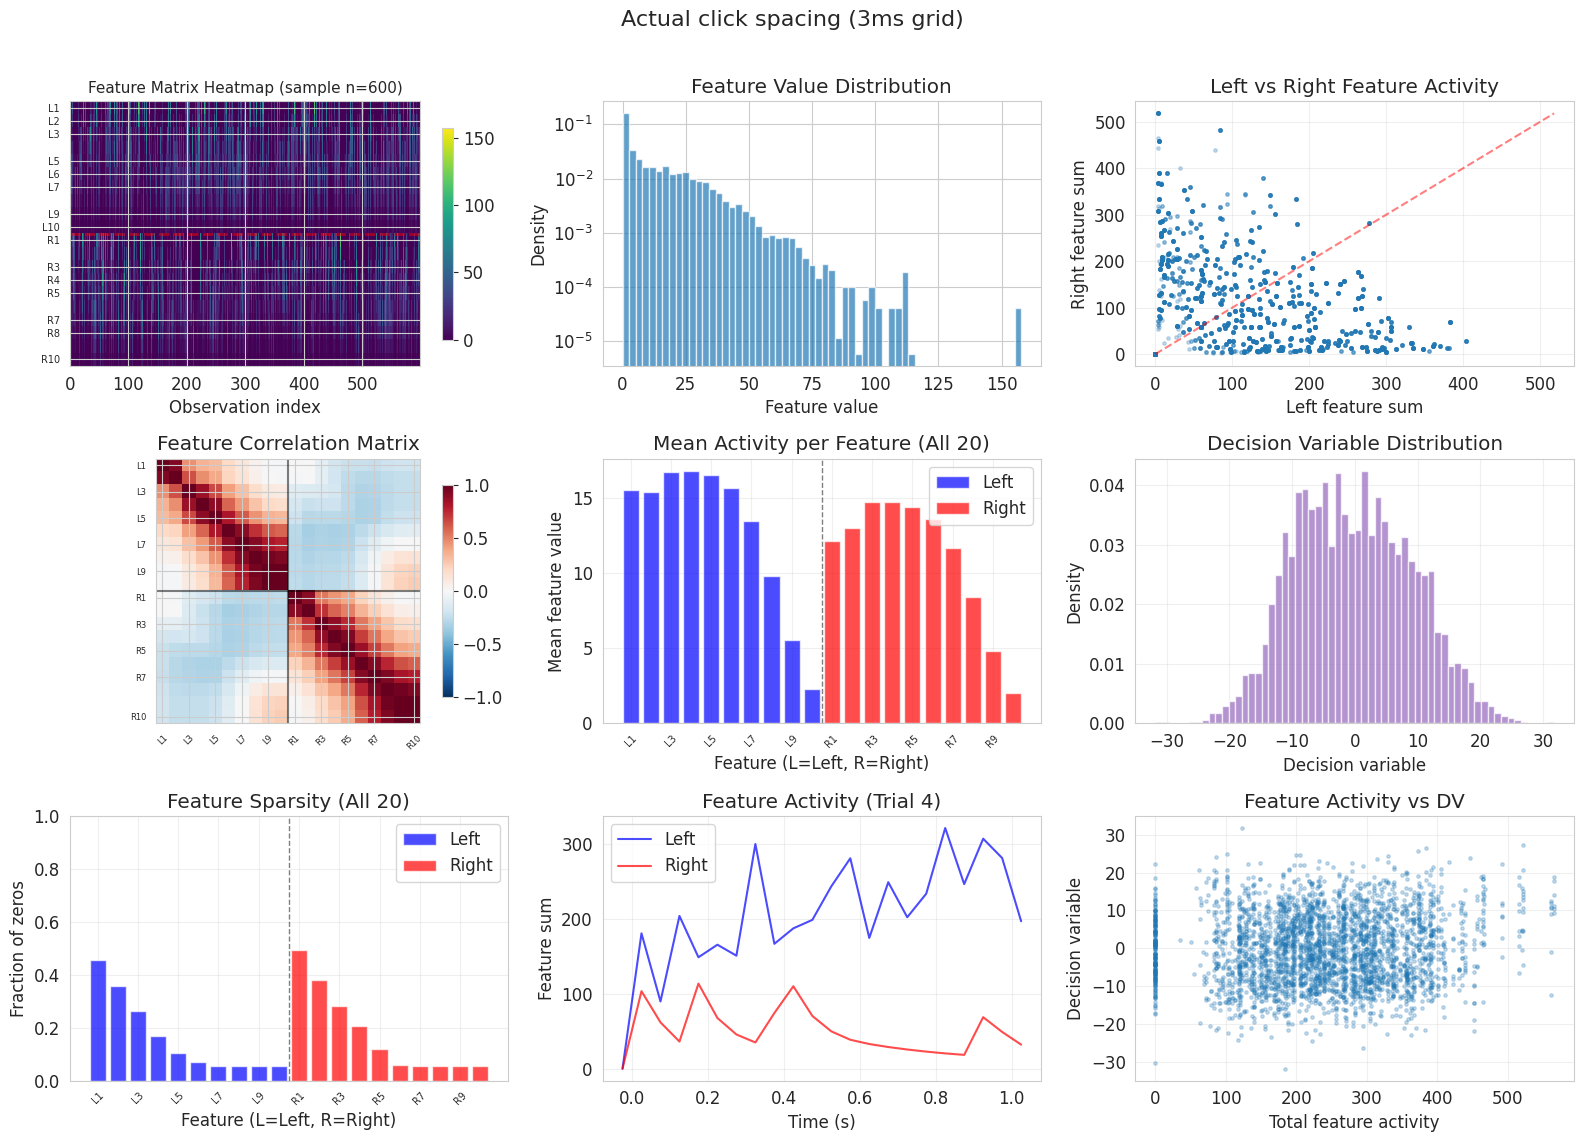

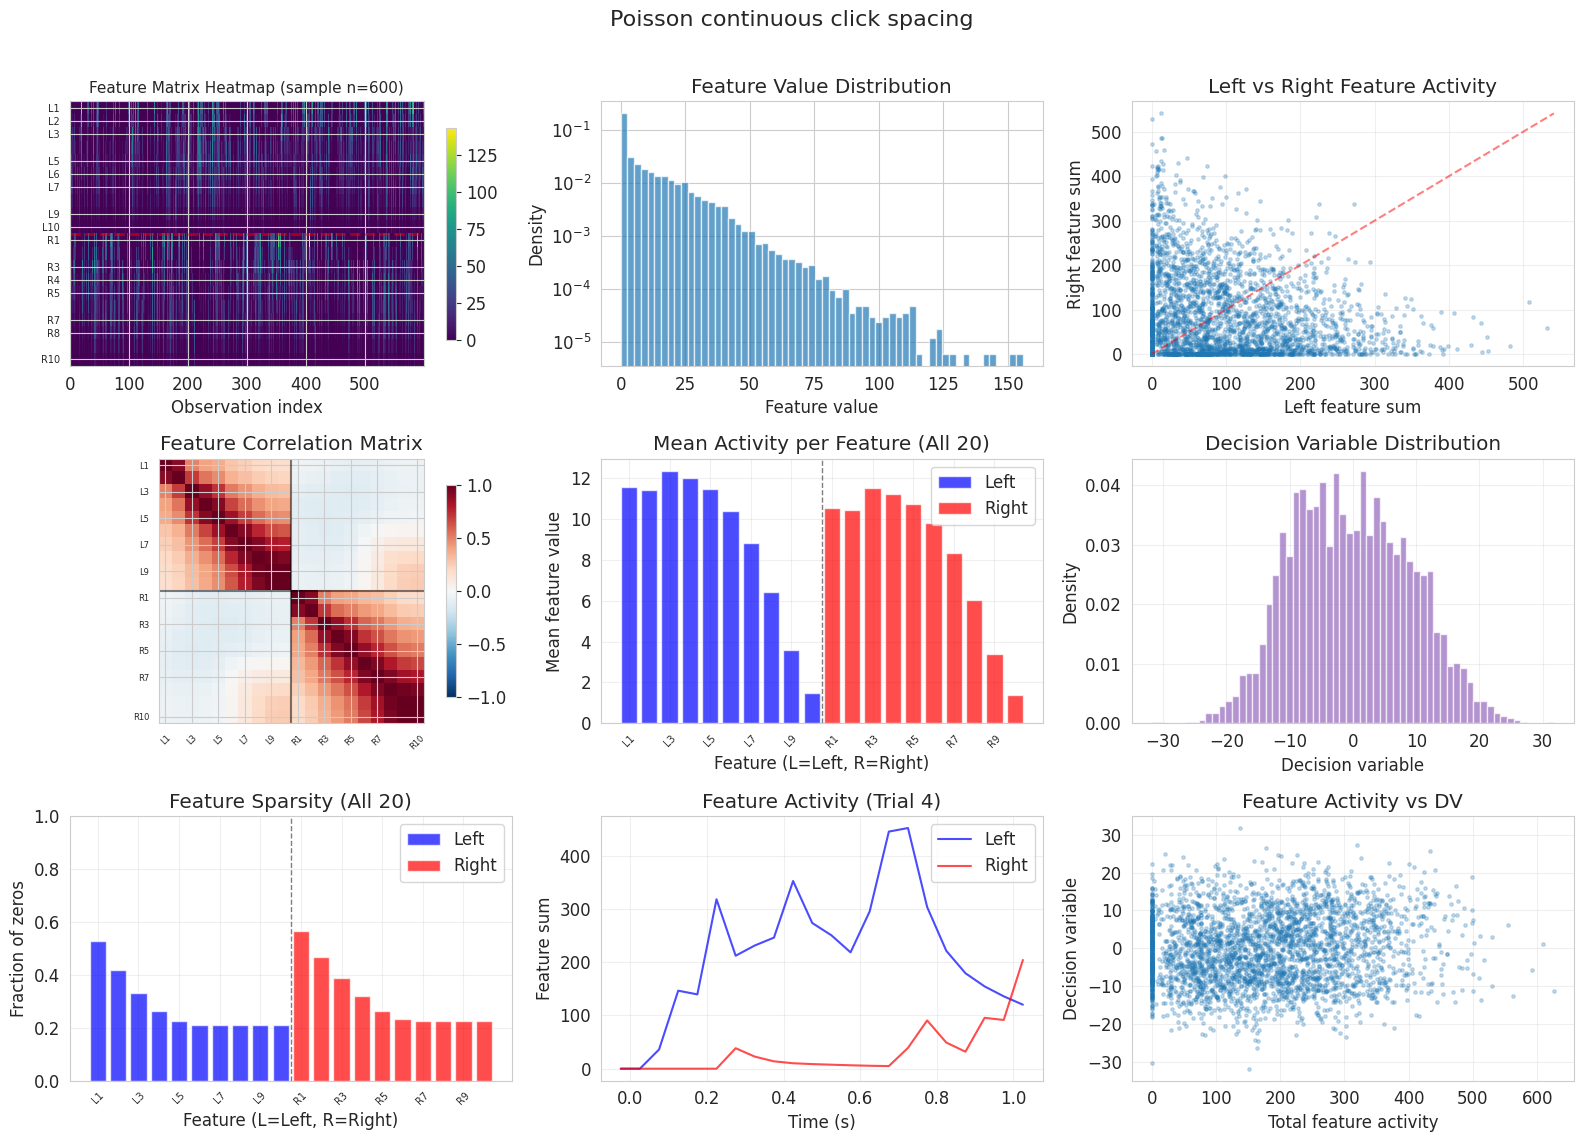

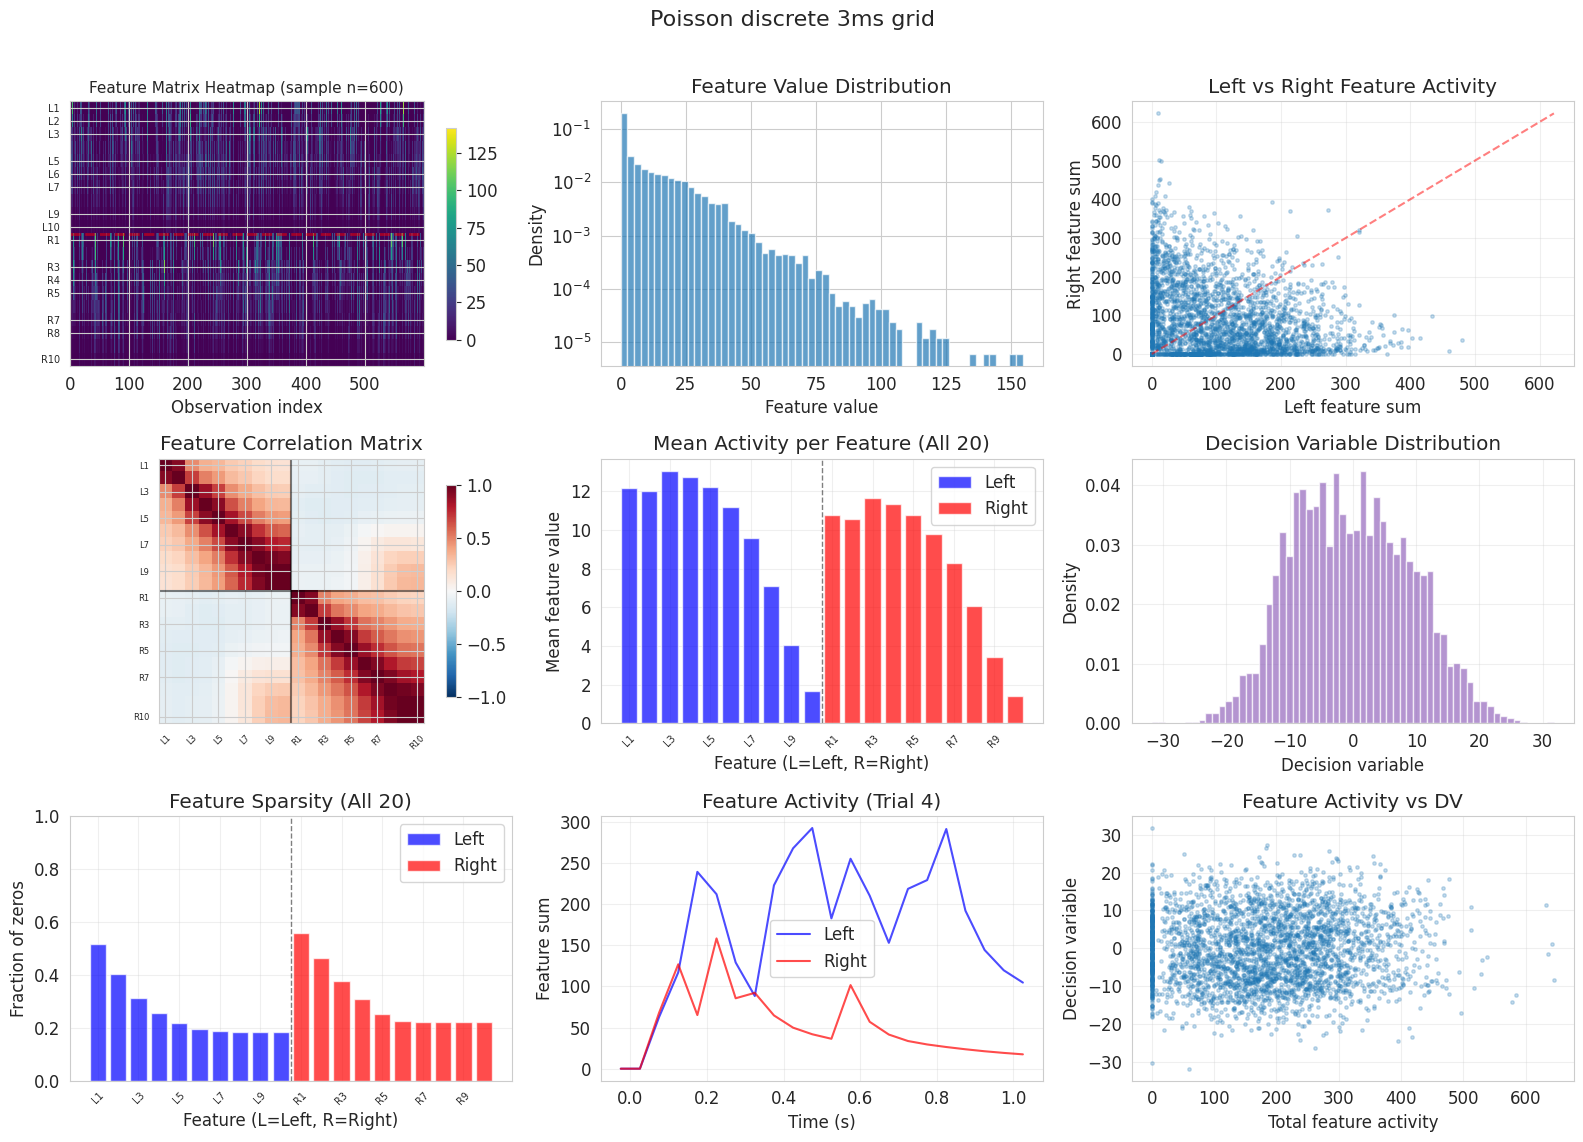

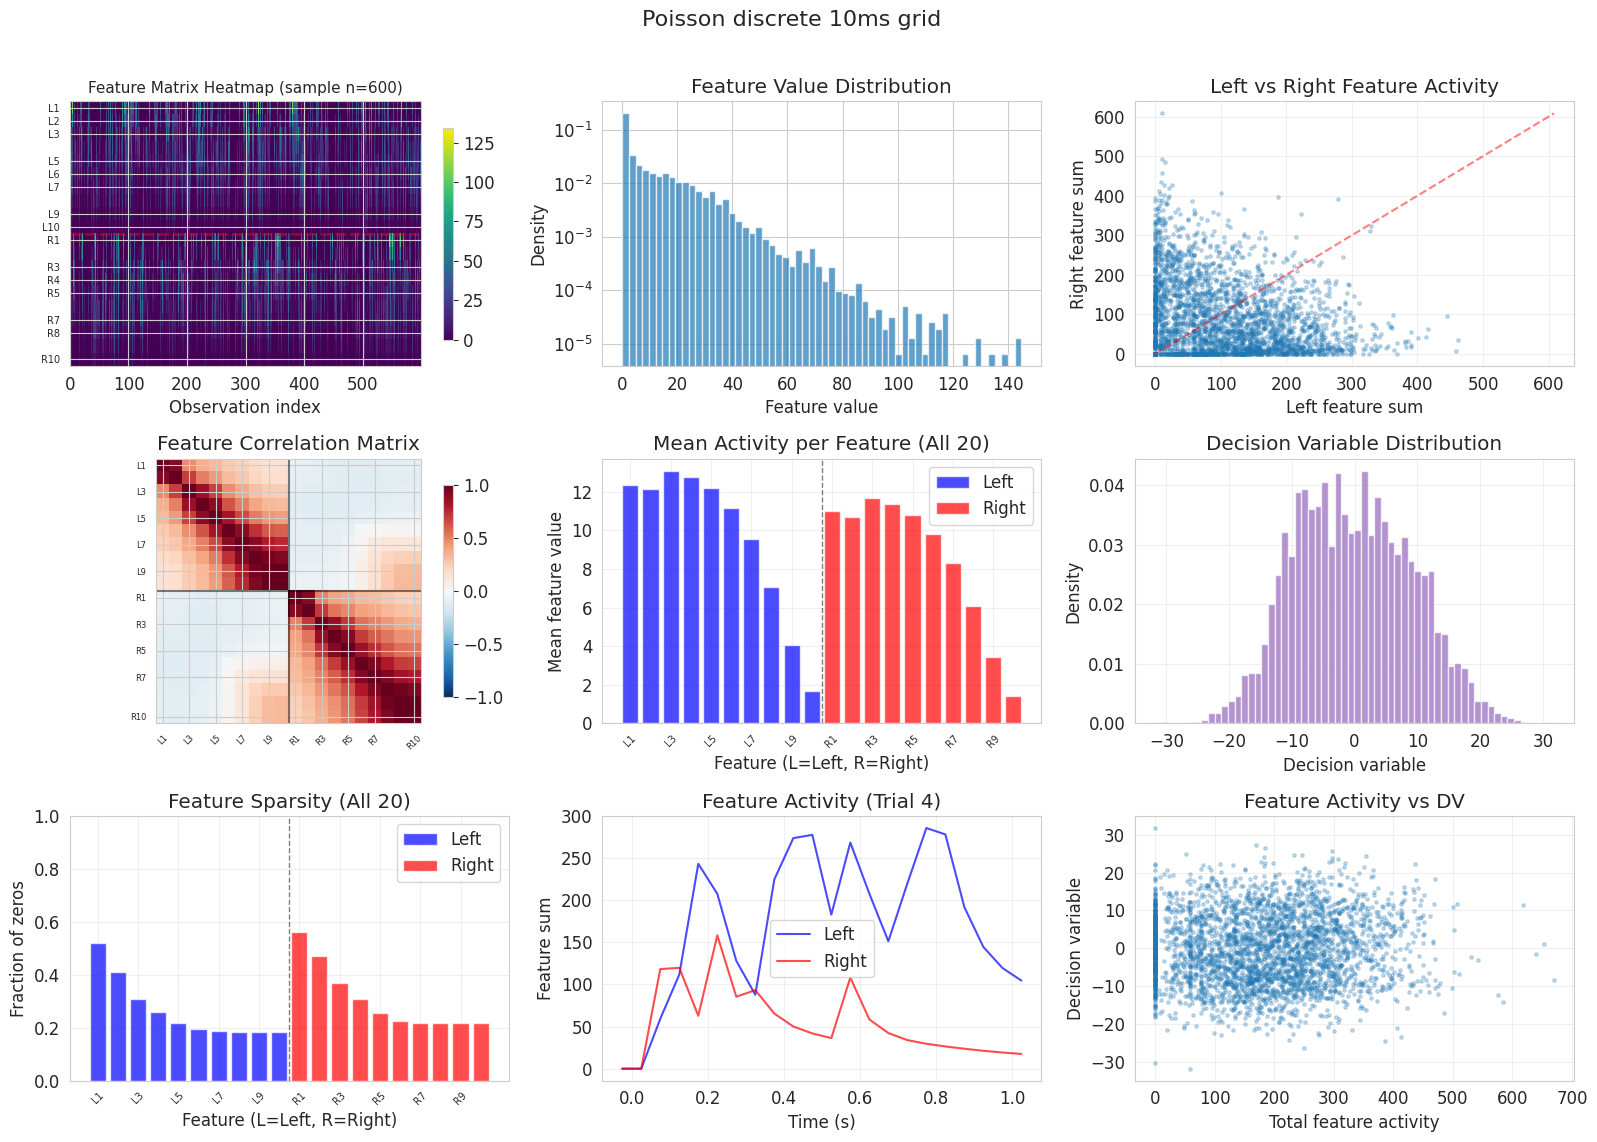

In [80]:
plot_feature_summary(actual_ds, n_basis=len(widths), title="Actual click spacing (3ms grid)")
plot_feature_summary(poisson_continuous_ds, n_basis=len(widths), title="Poisson continuous click spacing")
plot_feature_summary(poisson_3ms_ds, n_basis=len(widths), title="Poisson discrete 3ms grid")
plot_feature_summary(poisson_10ms_ds, n_basis=len(widths), title="Poisson discrete 10ms grid")

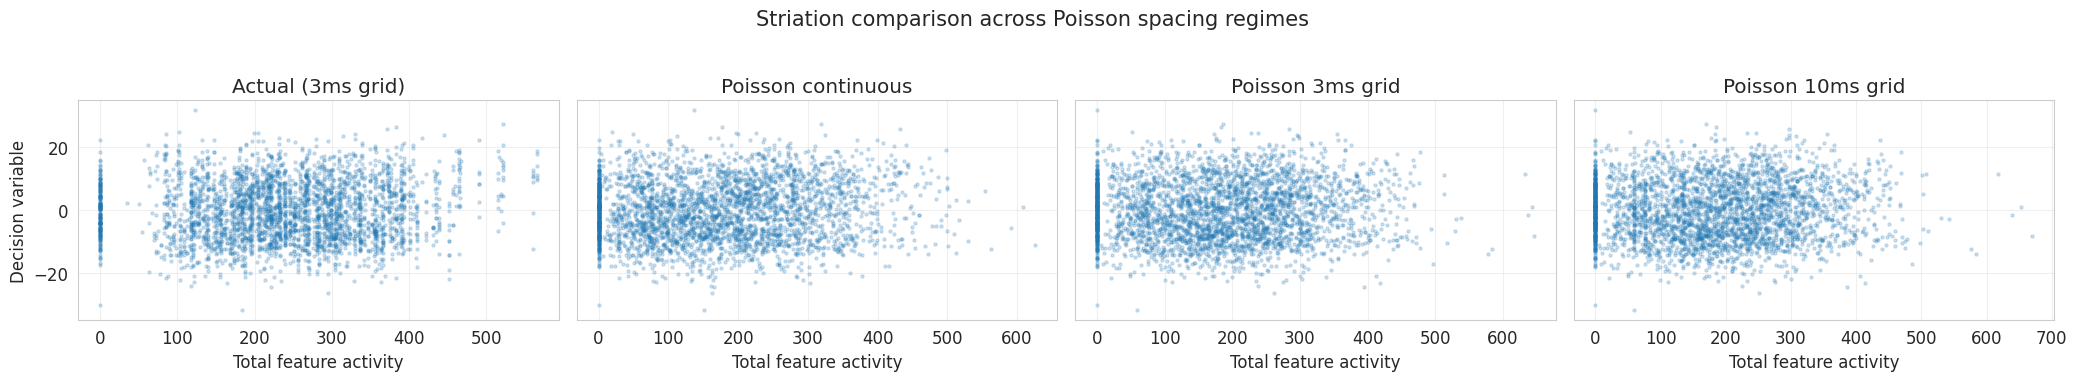

In [81]:
def compare_striation(datasets, labels, *, scatter_alpha: float = 0.2) -> None:
    fig, axes = plt.subplots(1, len(datasets), figsize=(5.2 * len(datasets), 4), sharey=True)
    if len(datasets) == 1:
        axes = [axes]

    for ax, dataset, label in zip(axes, datasets, labels):
        filtered = dataset.filtered()
        if filtered.X.size == 0:
            ax.set_visible(False)
            continue
        total_activity = filtered.X.sum(axis=1)
        ax.scatter(total_activity, filtered.y, alpha=scatter_alpha, s=5)
        ax.set_title(label)
        ax.set_xlabel("Total feature activity")
        ax.grid(True, alpha=0.3)
    axes[0].set_ylabel("Decision variable")
    fig.suptitle("Striation comparison across Poisson spacing regimes", fontsize=15)
    fig.tight_layout(rect=(0, 0.03, 1, 0.95))
    plt.show()


compare_striation(
    [actual_ds, poisson_continuous_ds, poisson_3ms_ds, poisson_10ms_ds],
    ["Actual (3ms grid)", "Poisson continuous", "Poisson 3ms grid", "Poisson 10ms grid"],
)


### Next Experiments
- Adjust `transform_kwargs` for **jittered** or **fixed** spacings (e.g. try `interval_ms=5`, `interval_ms=20`).
- Explore hybrid strategies (e.g. random on one side, fixed on the other) by preprocessing `click_df_subset` prior to calling `build_feature_dataset`.
- Feed these feature matrices into the GLM training pipeline to quantify performance differences alongside the visual diagnostics.


### How the synthetic spacing trials use DV values
The decision-variable targets (`y`) always come directly from the `decision_variable` column in the recorded session (`dv_df_subset`). When we generate alternative click spacing (random or the exponential-quantised 10 ms grid), we only alter the **feature matrix** by repositioning the clicks before convolution. The GLM therefore sees the same DV trajectory for every spacing mode—it simply receives different feature representations when fitting the model.


## Multiple Grid Size Comparison

Now let's systematically compare different grid sizes to see how discretization level affects striations:

In [82]:
# Build datasets for multiple grid sizes
grid_sizes = [1, 3, 5, 10, 20]  # milliseconds

print("Building datasets for multiple grid sizes...")
multi_grid_datasets = build_multiple_grid_datasets(
    click_df_subset,
    dv_df_subset,
    grid_sizes_ms=grid_sizes,
    centers=centers,
    widths=widths,
    trial_ids=trial_subset,
    rng_seed=123
)

# Add actual and continuous for comparison
multi_grid_datasets["actual"] = actual_ds
multi_grid_datasets["continuous"] = poisson_continuous_ds

print(f"\nCreated {len(multi_grid_datasets)} datasets")
for name, ds in multi_grid_datasets.items():
    filtered = ds.filtered()
    print(f"  {name:12} → {len(filtered.y)} observations")

Building datasets for multiple grid sizes...
Building dataset for 1ms grid (collisions=allowed)...


Building feature matrix: 100%|██████████| 186/186 [01:08<00:00,  2.72it/s]


Building dataset for 3ms grid (collisions=allowed)...


Building feature matrix: 100%|██████████| 186/186 [01:10<00:00,  2.64it/s]


Building dataset for 5ms grid (collisions=allowed)...


Building feature matrix: 100%|██████████| 186/186 [01:08<00:00,  2.71it/s]


Building dataset for 10ms grid (collisions=allowed)...


Building feature matrix: 100%|██████████| 186/186 [01:11<00:00,  2.62it/s]


Building dataset for 20ms grid (collisions=allowed)...


Building feature matrix: 100%|██████████| 186/186 [01:08<00:00,  2.71it/s]


Created 7 datasets
  1ms          → 3255 observations
  3ms          → 3255 observations
  5ms          → 3255 observations
  10ms         → 3255 observations
  20ms         → 3255 observations
  actual       → 3255 observations
  continuous   → 3255 observations


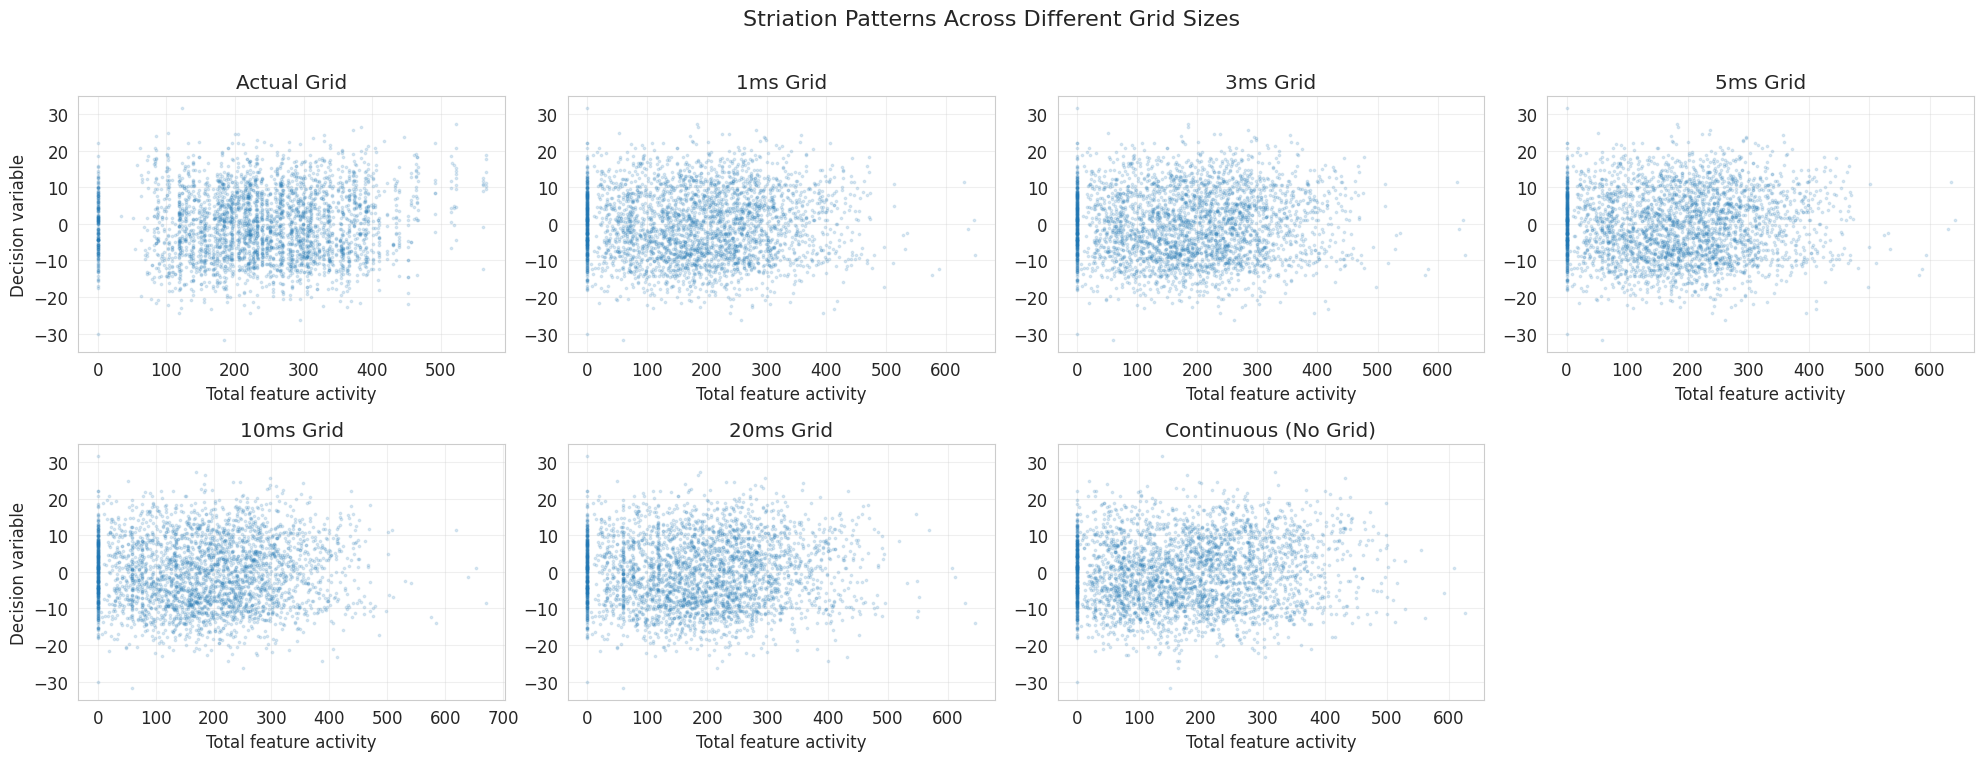

In [83]:
# Visualize striations across all grid sizes
def compare_multi_grid_striations(datasets_dict, order=None):
    """Compare striations across multiple grid sizes."""
    
    if order is None:
        order = ["actual", "1ms", "3ms", "5ms", "10ms", "20ms", "continuous"]
    
    # Filter to only include specified keys that exist
    datasets = [(k, datasets_dict[k]) for k in order if k in datasets_dict]
    
    n_plots = len(datasets)
    fig, axes = plt.subplots(2, (n_plots + 1) // 2, figsize=(5 * ((n_plots + 1) // 2), 8))
    axes = axes.flatten()
    
    for idx, (name, dataset) in enumerate(datasets):
        ax = axes[idx]
        filtered = dataset.filtered()
        
        if filtered.X.size > 0:
            total_activity = filtered.X.sum(axis=1)
            ax.scatter(total_activity, filtered.y, alpha=0.15, s=3)
            ax.set_title(f"{name.capitalize()} Grid" if name != "continuous" else "Continuous (No Grid)")
            ax.set_xlabel("Total feature activity")
            if idx % ((n_plots + 1) // 2) == 0:
                ax.set_ylabel("Decision variable")
            ax.grid(True, alpha=0.3)
        else:
            ax.set_visible(False)
    
    # Hide unused subplots
    for idx in range(len(datasets), len(axes)):
        axes[idx].set_visible(False)
    
    fig.suptitle("Striation Patterns Across Different Grid Sizes", fontsize=16)
    fig.tight_layout(rect=(0, 0.03, 1, 0.97))
    plt.show()

compare_multi_grid_striations(multi_grid_datasets)

## Click Spacing Analysis: Comparing Actual vs Synthetic Grids

Now let's analyze how different spacing modes affect the inter-click interval distributions:

In [84]:
def analyze_click_spacing(click_df, trial_subset, mode='actual', transform_kwargs=None, rng_seed=123):
    """
    Analyze inter-click intervals for different spacing modes.
    Returns intervals in milliseconds for left and right clicks.
    """
    transform_kwargs = transform_kwargs or {}
    rng = np.random.default_rng(rng_seed) if rng_seed else None
    
    left_intervals = []
    right_intervals = []
    all_intervals = []
    
    for trial_id in tqdm(trial_subset):
        trial_clicks = click_df[click_df['trial_id'] == trial_id]
        if len(trial_clicks) == 0:
            continue
            
        # Get click times
        left_clicks = trial_clicks[trial_clicks['click_side'] == 'left']['time_from_first_click'].values
        right_clicks = trial_clicks[trial_clicks['click_side'] == 'right']['time_from_first_click'].values
        
        # Get trial duration
        trial_dvs = dv_df_subset[dv_df_subset['trial_id'] == trial_id]
        if len(trial_dvs) > 0:
            trial_duration = trial_dvs['time_bin'].max() + 0.05
        else:
            trial_duration = 2.0  # Default
        
        # Transform click times if needed
        if mode != 'actual':
            left_clicks = transform_click_times(
                left_clicks, trial_duration, mode=mode, rng=rng, **transform_kwargs
            )
            right_clicks = transform_click_times(
                right_clicks, trial_duration, mode=mode, rng=rng, **transform_kwargs
            )
        
        # Calculate intervals
        if len(left_clicks) > 1:
            left_diffs = np.diff(np.sort(left_clicks)) * 1000  # Convert to ms
            left_intervals.extend(left_diffs[left_diffs > 0])
        
        if len(right_clicks) > 1:
            right_diffs = np.diff(np.sort(right_clicks)) * 1000  # Convert to ms
            right_intervals.extend(right_diffs[right_diffs > 0])
        
        # Combine all clicks for overall spacing
        all_clicks = np.sort(np.concatenate([left_clicks, right_clicks]))
        if len(all_clicks) > 1:
            all_diffs = np.diff(all_clicks) * 1000  # Convert to ms
            all_intervals.extend(all_diffs[all_diffs > 0])
    
    return {
        'left': np.array(left_intervals),
        'right': np.array(right_intervals),
        'all': np.array(all_intervals),
        'mode': mode
    }

# Analyze spacing for different conditions
print("Analyzing click spacing distributions...")

spacing_results = {
    'Actual (3ms)': analyze_click_spacing(click_df_subset, trial_subset, mode='actual'),
    'Poisson Continuous': analyze_click_spacing(
        click_df_subset, trial_subset, mode='poisson_continuous'
    ),
    'Poisson 10ms Grid': analyze_click_spacing(
        click_df_subset, trial_subset, mode='poisson_discrete_10ms'
    ),
    'Poisson 3ms Grid': analyze_click_spacing(
        click_df_subset, trial_subset, mode='poisson_discrete_3ms'
    ),
}

# Print summary statistics
for name, result in spacing_results.items():
    all_intervals = result['all']
    if len(all_intervals) > 0:
        print(f"\n{name}:")
        print(f"  Mean interval: {np.mean(all_intervals):.2f} ms")
        print(f"  Median interval: {np.median(all_intervals):.2f} ms")
        print(f"  Std interval: {np.std(all_intervals):.2f} ms")
        print(f"  Min interval: {np.min(all_intervals):.2f} ms")
        print(f"  Max interval: {np.max(all_intervals):.2f} ms")

Analyzing click spacing distributions...


100%|██████████| 186/186 [00:58<00:00,  3.18it/s]


Actual (3ms):
  Mean interval: 24.43 ms
  Median interval: 18.03 ms
  Std interval: 21.91 ms
  Min interval: 3.00 ms
  Max interval: 180.30 ms

Poisson Continuous:
  Mean interval: 34.95 ms
  Median interval: 20.46 ms
  Std interval: 43.87 ms
  Min interval: 0.00 ms
  Max interval: 581.69 ms

Poisson 10ms Grid:
  Mean interval: 41.73 ms
  Median interval: 30.00 ms
  Std interval: 44.48 ms
  Min interval: 10.00 ms
  Max interval: 560.00 ms

Poisson 3ms Grid:
  Mean interval: 37.45 ms
  Median interval: 24.00 ms
  Std interval: 43.78 ms
  Min interval: 3.00 ms
  Max interval: 558.00 ms


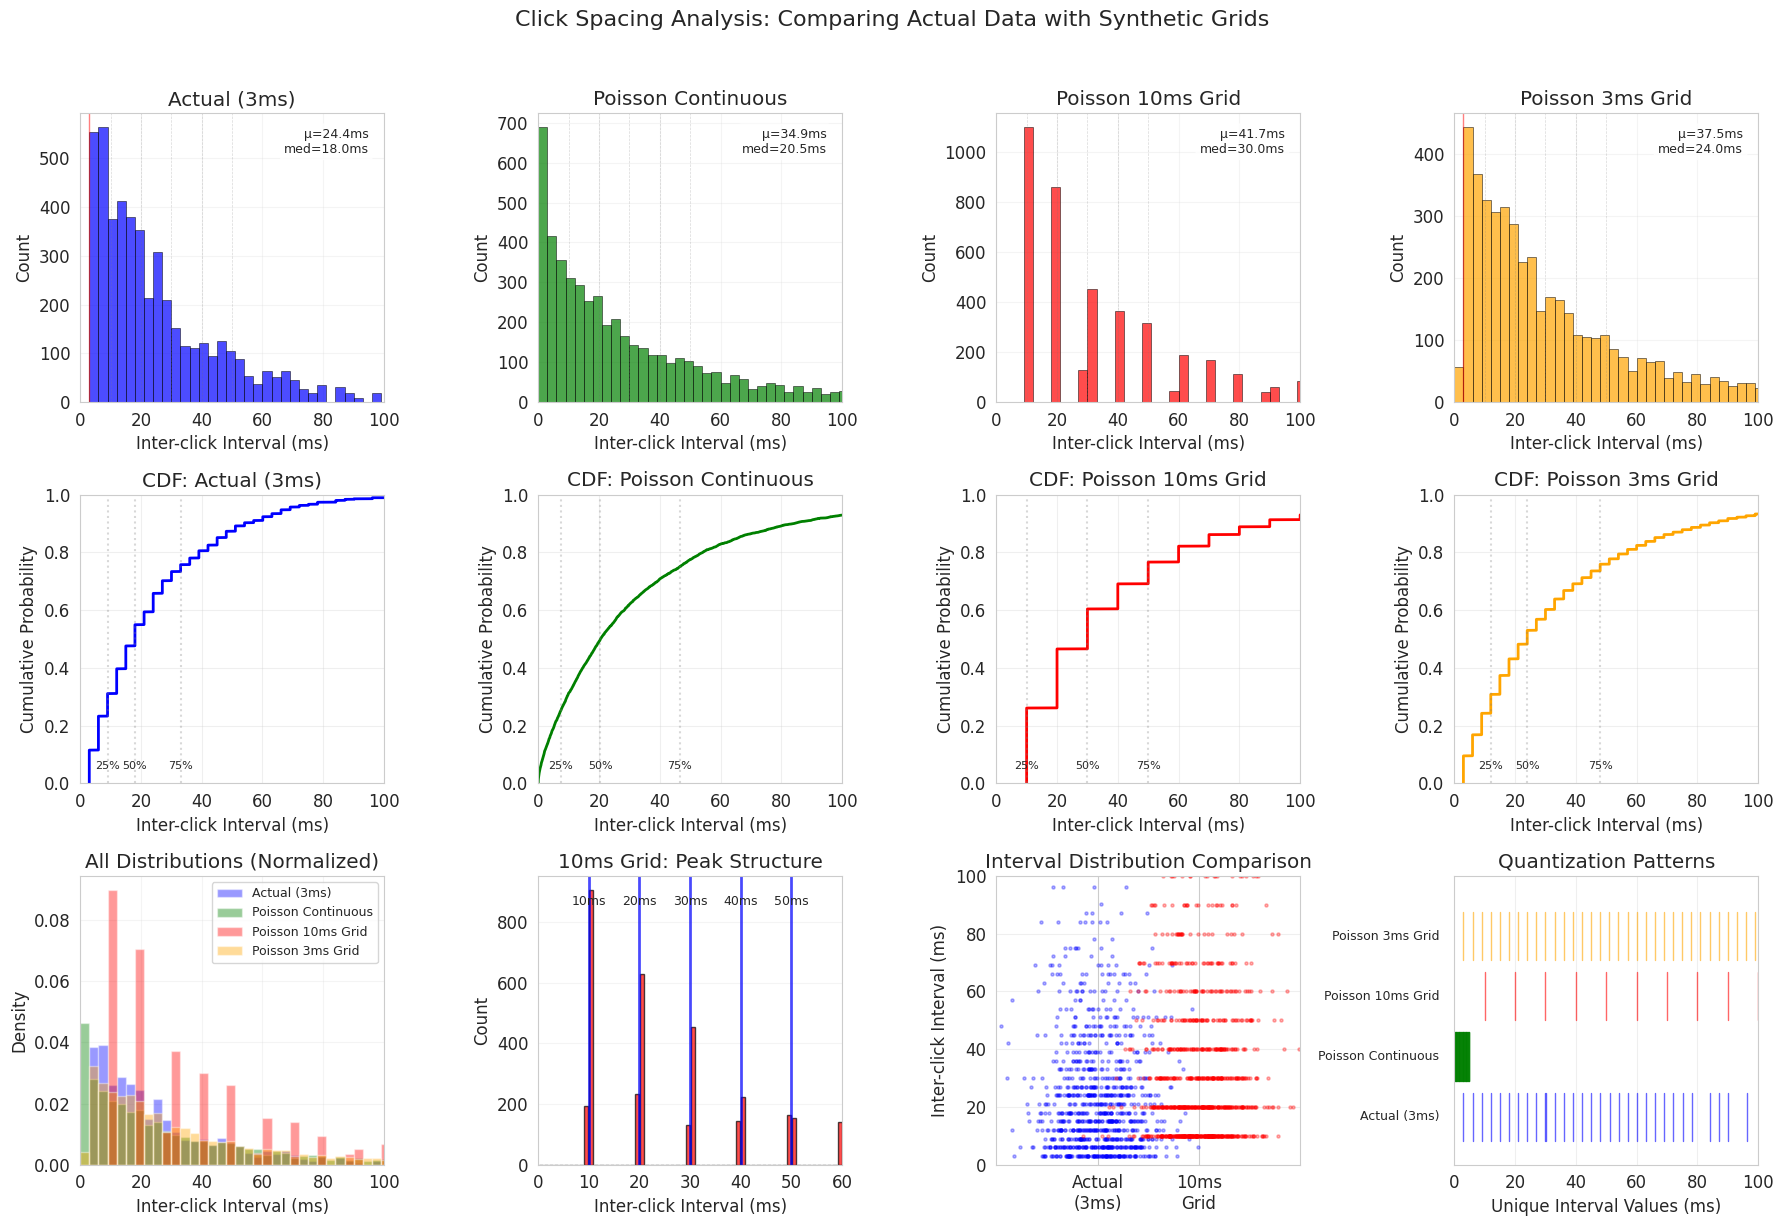


KEY OBSERVATIONS:

1. ACTUAL (3ms grid):
   - Shows peaks at multiples of 3ms
   - Smooth exponential-like decay overall

2. POISSON 10ms GRID:
   - Strong peaks at 10, 20, 30, 40ms
   - No intervals between these values
   - Creates distinct quantization

3. CONTINUOUS:
   - Smooth exponential distribution
   - No quantization artifacts


In [85]:
# Create comprehensive click spacing visualization
fig, axes = plt.subplots(3, 4, figsize=(18, 12))

# Define bin edges for histograms
bins = np.arange(0, 151, 3)  # 0 to 150ms in 3ms bins

# Color scheme for different conditions
colors = {
    'Actual (3ms)': 'blue',
    'Poisson Continuous': 'green', 
    'Poisson 10ms Grid': 'red',
    'Poisson 3ms Grid': 'orange'
}

# Row 1: Histograms for each condition
for idx, (name, result) in enumerate(spacing_results.items()):
    ax = axes[0, idx]
    intervals = result['all']
    
    if len(intervals) > 0:
        # Create histogram
        counts, edges, patches = ax.hist(intervals, bins=bins, alpha=0.7, 
                                         color=colors[name], edgecolor='black', linewidth=0.5)
        
        # Mark multiples of 10ms for reference
        for x in [10, 20, 30, 40, 50]:
            ax.axvline(x, color='gray', alpha=0.3, linestyle='--', linewidth=0.5)
        
        # Add vertical line at 3ms for actual data reference
        if '3ms' in name:
            ax.axvline(3, color='red', alpha=0.5, linestyle='-', linewidth=1, label='3ms')
        
        ax.set_xlabel('Inter-click Interval (ms)')
        ax.set_ylabel('Count')
        ax.set_title(f'{name}')
        ax.set_xlim(0, 100)
        ax.grid(True, alpha=0.2)
        
        # Add statistics text
        mean_val = np.mean(intervals)
        median_val = np.median(intervals)
        ax.text(0.95, 0.95, f'μ={mean_val:.1f}ms\nmed={median_val:.1f}ms',
                transform=ax.transAxes, ha='right', va='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                fontsize=9)

# Row 2: Cumulative distributions
for idx, (name, result) in enumerate(spacing_results.items()):
    ax = axes[1, idx]
    intervals = result['all']
    
    if len(intervals) > 0:
        # Sort intervals for CDF
        sorted_intervals = np.sort(intervals)
        cdf = np.arange(1, len(sorted_intervals) + 1) / len(sorted_intervals)
        
        ax.plot(sorted_intervals, cdf, color=colors[name], linewidth=2)
        ax.set_xlabel('Inter-click Interval (ms)')
        ax.set_ylabel('Cumulative Probability')
        ax.set_title(f'CDF: {name}')
        ax.set_xlim(0, 100)
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.3)
        
        # Mark percentiles
        percentiles = [25, 50, 75]
        for p in percentiles:
            val = np.percentile(intervals, p)
            ax.axvline(val, color='gray', alpha=0.3, linestyle=':')
            ax.text(val, 0.05, f'{p}%', ha='center', fontsize=8)

# Row 3: Direct comparisons
# Panel 1: Overlay of all distributions
ax = axes[2, 0]
for name, result in spacing_results.items():
    intervals = result['all']
    if len(intervals) > 0:
        ax.hist(intervals, bins=bins, alpha=0.4, label=name, 
                color=colors[name], density=True)

ax.set_xlabel('Inter-click Interval (ms)')
ax.set_ylabel('Density')
ax.set_title('All Distributions (Normalized)')
ax.set_xlim(0, 100)
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.2)

# Panel 2: Focus on 10ms grid peaks
ax = axes[2, 1]
intervals_10ms = spacing_results['Poisson 10ms Grid']['all']
if len(intervals_10ms) > 0:
    # Fine bins around multiples of 10
    fine_bins = np.arange(0, 61, 1)
    counts, edges = np.histogram(intervals_10ms, bins=fine_bins)
    centers = (edges[:-1] + edges[1:]) / 2
    
    ax.bar(centers, counts, width=0.8, alpha=0.7, color='red', edgecolor='black')
    
    # Mark exact multiples of 10ms
    for x in [10, 20, 30, 40, 50]:
        ax.axvline(x, color='blue', alpha=0.7, linestyle='-', linewidth=2)
        ax.text(x, ax.get_ylim()[1]*0.9, f'{x}ms', ha='center', fontsize=9)
    
    ax.set_xlabel('Inter-click Interval (ms)')
    ax.set_ylabel('Count')
    ax.set_title('10ms Grid: Peak Structure')
    ax.set_xlim(0, 60)
    ax.grid(True, alpha=0.2)

# Panel 3: Actual vs 10ms grid scatter
ax = axes[2, 2]
actual_intervals = spacing_results['Actual (3ms)']['all']
grid10_intervals = spacing_results['Poisson 10ms Grid']['all']

# Sample for visualization if too many points
n_sample = min(1000, min(len(actual_intervals), len(grid10_intervals)))
if n_sample > 0:
    actual_sample = np.random.choice(actual_intervals, n_sample, replace=False)
    grid10_sample = np.random.choice(grid10_intervals, n_sample, replace=False)
    
    # Add jitter for visibility
    jitter = np.random.normal(0, 0.3, n_sample)
    ax.scatter(np.ones(n_sample) + jitter, actual_sample, alpha=0.3, s=5, color='blue', label='Actual')
    ax.scatter(2*np.ones(n_sample) + jitter, grid10_sample, alpha=0.3, s=5, color='red', label='10ms Grid')
    
    ax.set_xlim(0, 3)
    ax.set_ylim(0, 100)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Actual\n(3ms)', '10ms\nGrid'])
    ax.set_ylabel('Inter-click Interval (ms)')
    ax.set_title('Interval Distribution Comparison')
    ax.grid(True, alpha=0.3, axis='y')

# Panel 4: Quantization effects
ax = axes[2, 3]

# Show unique values for each condition to highlight quantization
for i, (name, result) in enumerate(spacing_results.items()):
    intervals = result['all']
    if len(intervals) > 0:
        # Round to nearest ms and find unique values
        unique_vals = np.unique(np.round(intervals, 1))
        
        # Plot as vertical lines
        y_base = i * 0.25
        for val in unique_vals[:50]:  # Limit to first 50 unique values
            ax.plot([val, val], [y_base, y_base + 0.2], 
                   color=colors[name], alpha=0.6, linewidth=1)
    
        ax.text(-5, y_base + 0.1, name, ha='right', va='center', fontsize=9)

ax.set_xlim(0, 100)
ax.set_ylim(-0.1, 1.1)
ax.set_xlabel('Unique Interval Values (ms)')
ax.set_title('Quantization Patterns')
ax.set_yticks([])
ax.grid(True, alpha=0.3, axis='x')

plt.suptitle('Click Spacing Analysis: Comparing Actual Data with Synthetic Grids', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("KEY OBSERVATIONS:")
print("="*60)
print("\n1. ACTUAL (3ms grid):")
print("   - Shows peaks at multiples of 3ms")
print("   - Smooth exponential-like decay overall")
print("\n2. POISSON 10ms GRID:")
print("   - Strong peaks at 10, 20, 30, 40ms")
print("   - No intervals between these values")
print("   - Creates distinct quantization")
print("\n3. CONTINUOUS:")
print("   - Smooth exponential distribution")
print("   - No quantization artifacts")

## Comparing Collision Modes: Unique vs Multiple Clicks per Grid Position

Now let's compare how allowing multiple clicks per grid position (collisions) affects the spacing distributions and striation patterns:

In [86]:
# Build datasets with and without allowing collisions for 10ms grid
print("Building 10ms grid datasets with different collision modes...")

# With collisions allowed (NEW default behavior)
poisson_10ms_collisions = build_feature_dataset(
    click_df_subset,
    dv_df_subset,
    spacing_mode="poisson_discrete_10ms",
    transform_kwargs={"allow_collisions": True},  # Explicitly set
    **common_dataset_kwargs,
)

# Without collisions (legacy behavior - unique positions only)
poisson_10ms_no_collisions = build_feature_dataset(
    click_df_subset,
    dv_df_subset,
    spacing_mode="poisson_discrete_10ms",
    transform_kwargs={"allow_collisions": False},  # Force unique
    **common_dataset_kwargs,
)

print("\nDatasets created:")
describe_dataset("10ms with collisions", poisson_10ms_collisions)
describe_dataset("10ms no collisions", poisson_10ms_no_collisions)

Building 10ms grid datasets with different collision modes...


Building feature matrix:   8%|▊         | 14/186 [00:48<10:00,  3.49s/it]


KeyboardInterrupt: 

In [ ]:
# Analyze click spacing for collision modes
def analyze_collisions(click_df, trial_subset, mode='poisson_discrete_10ms', allow_collisions=True, rng_seed=123):
    """Analyze how many collisions occur with different modes."""
    rng = np.random.default_rng(rng_seed)
    
    total_clicks = 0
    total_collisions = 0
    intervals_all = []
    
    for trial_id in trial_subset[:20]:  # Sample first 20 trials for speed
        trial_clicks = click_df[click_df['trial_id'] == trial_id]
        if len(trial_clicks) == 0:
            continue
        
        # Get all clicks
        all_clicks_orig = trial_clicks['time_from_first_click'].values
        
        # Transform
        trial_dvs = dv_df_subset[dv_df_subset['trial_id'] == trial_id]
        trial_duration = trial_dvs['time_bin'].max() + 0.05 if len(trial_dvs) > 0 else 2.0
        
        all_clicks_transformed = transform_click_times(
            all_clicks_orig, trial_duration, 
            mode=mode, rng=rng, 
            allow_collisions=allow_collisions
        )
        
        # Count collisions (zero intervals)
        if len(all_clicks_transformed) > 1:
            intervals = np.diff(np.sort(all_clicks_transformed)) * 1000  # ms
            intervals_all.extend(intervals)
            n_collisions = np.sum(intervals == 0)
            total_collisions += n_collisions
            total_clicks += len(all_clicks_transformed)
    
    intervals_all = np.array(intervals_all)
    collision_rate = total_collisions / max(total_clicks, 1)
    
    return {
        'intervals': intervals_all,
        'n_zero_intervals': np.sum(intervals_all == 0),
        'collision_rate': collision_rate,
        'unique_intervals': len(np.unique(intervals_all)),
        'total_clicks': total_clicks
    }

# Analyze both modes
print("Analyzing collision patterns...")

collision_analysis = {
    'With Collisions': analyze_collisions(
        click_df_subset, trial_subset, allow_collisions=True
    ),
    'No Collisions': analyze_collisions(
        click_df_subset, trial_subset, allow_collisions=False
    )
}

print("\nCollision Analysis Results (10ms grid):")
print("="*50)
for name, stats in collision_analysis.items():
    print(f"\n{name}:")
    print(f"  Zero intervals: {stats['n_zero_intervals']}")
    print(f"  Collision rate: {stats['collision_rate']:.1%}")
    print(f"  Unique interval values: {stats['unique_intervals']}")
    print(f"  Total clicks analyzed: {stats['total_clicks']}")

# Visualize the difference
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Histogram comparison
ax = axes[0]
bins = np.arange(0, 61, 1)  # 1ms bins up to 60ms

for name, stats in collision_analysis.items():
    intervals = stats['intervals']
    ax.hist(intervals, bins=bins, alpha=0.5, label=name, density=True)

# Mark 10ms multiples
for x in [0, 10, 20, 30, 40, 50]:
    ax.axvline(x, color='gray', alpha=0.3, linestyle='--', linewidth=0.5)
    if x == 0:
        ax.text(x+0.5, ax.get_ylim()[1]*0.9, '0ms\n(collision)', 
                ha='left', fontsize=8, color='red')

ax.set_xlabel('Inter-click Interval (ms)')
ax.set_ylabel('Density')
ax.set_title('Interval Distribution: Collision Modes')
ax.legend()
ax.set_xlim(-1, 60)

# Plot 2: Unique values visualization
ax = axes[1]
for i, (name, stats) in enumerate(collision_analysis.items()):
    intervals = stats['intervals']
    unique_vals = np.unique(intervals)[:30]  # First 30 unique values
    
    y_base = i * 0.5
    for val in unique_vals:
        height = np.sum(intervals == val) / len(intervals)  # Proportion
        ax.bar(val, height, bottom=y_base, width=0.8, 
               alpha=0.7, color=['blue', 'red'][i])
    
    ax.text(-2, y_base + 0.25, name, ha='right', va='center', fontsize=10)

ax.set_xlabel('Interval Value (ms)')
ax.set_ylabel('Relative Frequency (stacked)')
ax.set_title('Unique Interval Values')
ax.set_xlim(-3, 60)

# Plot 3: Striation comparison
ax = axes[2]
datasets_collision = {
    'With Collisions': poisson_10ms_collisions,
    'No Collisions': poisson_10ms_no_collisions
}

for i, (name, dataset) in enumerate(datasets_collision.items()):
    filtered = dataset.filtered()
    total_activity = filtered.X.sum(axis=1)
    
    # Subsample for visibility
    n_sample = min(1000, len(total_activity))
    sample_idx = np.random.choice(len(total_activity), n_sample, replace=False)
    
    # Add horizontal offset for visibility
    x_vals = total_activity[sample_idx]
    y_vals = filtered.y[sample_idx]
    x_jitter = i * 0.02 * (x_vals.max() - x_vals.min())
    
    ax.scatter(x_vals + x_jitter, y_vals, alpha=0.3, s=5, 
              label=name, color=['blue', 'red'][i])

ax.set_xlabel('Total Feature Activity')
ax.set_ylabel('Decision Variable')
ax.set_title('Striation Patterns: Collision Modes')
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('Effect of Allowing Multiple Clicks per Grid Position (10ms Grid)', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("KEY FINDINGS:")
print("="*60)
print("\n1. WITH COLLISIONS (Realistic):")
print("   - Multiple clicks can occupy same grid position")
print("   - Creates zero-interval spacings")
print("   - More realistic simulation of actual experiment")
print("\n2. WITHOUT COLLISIONS (Forced Unique):")
print("   - Each click forced to unique grid position")
print("   - No zero intervals possible")
print("   - May underestimate click density at popular times")